<a href="https://colab.research.google.com/github/roshantac/EVA4/blob/master/Assignment15/B/BothFinal2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!!nvidia-smi

['Sun May 24 16:30:42 2020       ',
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|===============================+======================+======================|',
 '|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |',
 '| N/A   46C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |',
 '+-------------------------------+----------------------+----------------------+',
 '                                                                               ',
 '+-----------------------------------------------------------------------------+',
 '| Processes:                          

In [0]:
 %matplotlib inline

In [10]:
!pip install kornia
from kornia.losses import SSIM

In [5]:
!git clone https://github.com/roshantac/Unet.git

Cloning into 'Unet'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 67 (delta 28), reused 38 (delta 13), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [0]:
!mkdir Unet/data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir Dataset
!cp '/content/drive/My Drive/Rohit dataset/Dataset.zip' Dataset


In [0]:
destDataDir = '/content/Dataset/'
path_to_zip_file = '/content/Dataset/Dataset.zip'
import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(destDataDir)

In [1]:
%cd Unet/

/content/Unet


In [0]:
pwd

'/content/Unet'

In [0]:
import argparse
import logging
import os
import sys
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
from eval import eval_net
from unet import UNet
from torch.utils.tensorboard import SummaryWriter
from utils.dataset import BasicDataset
from torch.utils.data import DataLoader, random_split

In [0]:
root = '/content/'
def getData(root,batch_size ,val_percent):
    dataset = BasicDataset(root)
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train, val = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, drop_last=True)
    return train_loader,val_loader

trainLoader, testLoader = getData(root,32,0.9)

In [0]:
import torchvision
import matplotlib.pyplot as plt

def show(tensors, figsize= (10,10), *args, **kwargs):
  try:
    tensors = tensors.detach().cpu()
  except:
    pass
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)  
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])
  plt.show()

In [0]:
def show_pred(tensors, *args, **kwargs):
  tensors = (tensors * std[None, : , None, None]) + mean[None, :, None, None]
  show(tensors, *args, **kwargs)

In [0]:
sample = next(iter(testLoader))

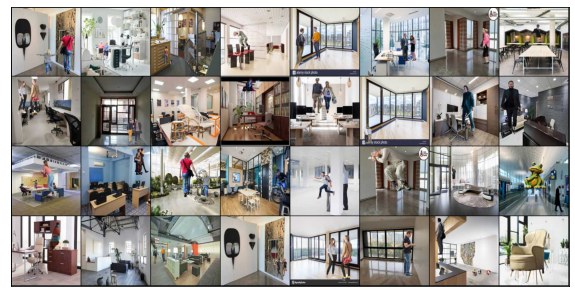

In [7]:
show(sample['fgbg'], nrow=8)

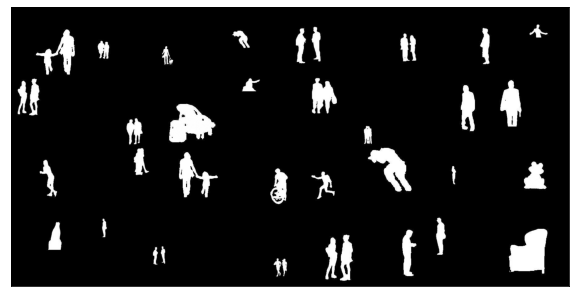

In [8]:
show(sample['mask'],nrow=8)

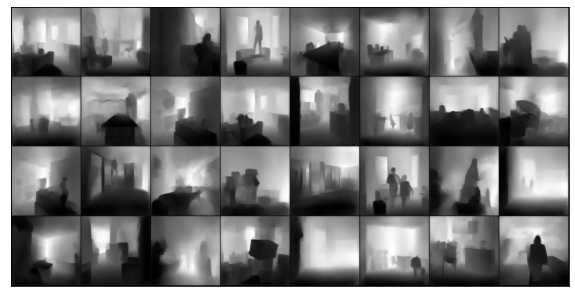

In [9]:
show(sample['depth'],nrow=8)

In [0]:
def draw_and_save(tensors, name, figsize=(20,20),*args,**kwargs):
  try:
    tensors = tensors.detach().cpu()
  except:
    pass
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)  
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])
  plt.savefig(name,bbox_inches='tight')
  plt.close()

In [0]:
def train_net(net, device,train_loader, epochs , lr ):
    import datetime
    global_step = 0
    optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    #criterion = nn.BCEWithLogitsLoss()
    criterion = SSIM(5, reduction = 'mean')
    n_train =len(train_loader)
    init = datetime.datetime.now()
    for epoch in range(epochs):
        start =  datetime.datetime.now()
        net.train()
        epoch_loss = 0  
        pbar = tqdm(train_loader)
        #with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:

        for i,batch in enumerate(pbar):
            batch['bg'] = batch['bg'].to(device, dtype = torch.float32)
            batch['fgbg'] = batch['fgbg'].to(device, dtype = torch.float32)
            batch['mask'] = batch['mask'].to(device, dtype = torch.float32)
            batch['depth'] = batch['depth'].to(device, dtype = torch.float32) 
            #depth_pred, masks_pred
            output = net(batch)
            loss1 = criterion(output[1], batch['mask'])
            loss2 = criterion(output[0], batch['depth']) 
            loss = loss1 + loss2 
            epoch_loss += loss.item()
            pbar.set_postfix(desc  = f'Epoch : {epoch+1}  Loss : {loss.item()}  l1: {loss1.item()} l2 = {loss2.item()}')
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(net.parameters(), 0.1)
            optimizer.step()
        scheduler.step() #loss
        end=  datetime.datetime.now()
        print("Time taken for epoch is: ", end-start)
        print(" Total time taken is : ", end -init)
        print("ground truth")
        show(batch['depth'].detach().cpu(),nrow=8)
        print("Depth")
        show(output[0].detach().cpu(),nrow=8) # depth
        print("mask")
        show(output[1].detach().cpu(),nrow=8) #mask


In [8]:

net = UNet(n_channels=6, n_classes=1, bilinear=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device=device)


UNet(
  (inc_m): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1_m): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentu

100%|██████████| 1250/1250 [27:51<00:00,  1.34s/it, desc=Epoch : 1  Loss : 1.499998927116394  l1: 0.49999892711639404 l2 = 0.5]


Time taken for epoch is:  0:27:51.106420
 Total time taken is :  0:27:51.106428
ground truth


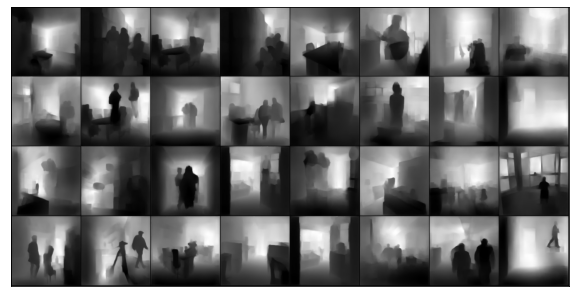

Depth


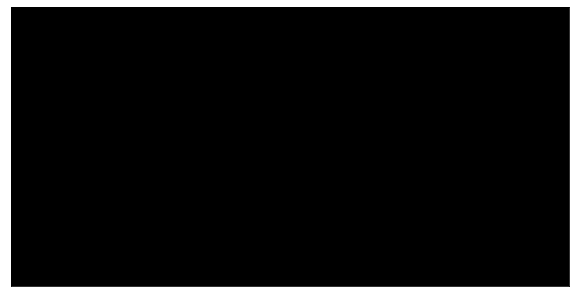

mask


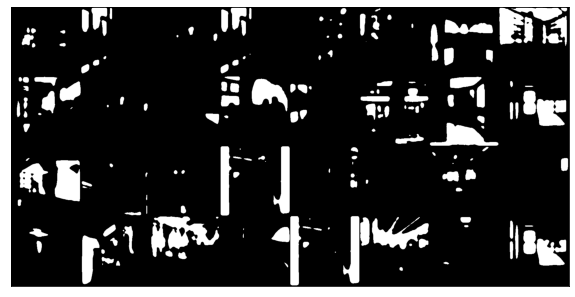

  7%|▋         | 91/1250 [02:02<25:27,  1.32s/it, desc=Epoch : 2  Loss : 1.4999992847442627  l1: 0.4999992251396179 l2 = 0.5]

In [0]:
logging.info(f'Using device {device}')
net =torch.nn.DataParallel(net)
torch.backends.cudnn.benchmark=True
# Train
train_net(net,device, trainLoader, 15, 0.1)